## Import Libraries

In [1]:
!pip install pythainlp
!pip install tensorboard
!pip install --upgrade pytorch-lightning
!pip -q install torch==1.5.0 torchtext==0.4.0 torchvision==0.6.0
!pip -q install transformers==3.5.0 thai2transformers==0.1.2

Requirement already up-to-date: pytorch-lightning in /usr/local/lib/python3.7/dist-packages (1.3.5)


In [47]:
import ast
import json
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pythainlp
import itertools
import os

from pythainlp.util import normalize
from transformers import pipeline
from thai2transformers.tokenizers import ThaiWordsNewmmTokenizer
from collections import Counter
from sklearn import metrics
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

In [3]:
import keras
import keras.backend as k

from keras.preprocessing.sequence import pad_sequences 
from keras.models import *
from keras.layers import *
from keras.callbacks import *

## Load Dataset

In [4]:
directory = '/content/drive/MyDrive/Educations/NIDA DS/2563-2/BADS7604 DEEP LEARNING/2 Assignment/2 Final/'

In [5]:
def read_data(room):
  with open(directory + '1 Scrape Data/{}.txt'.format(room), encoding="utf8") as json_file:
    data = json.loads(json.load(json_file))
    df = pd.DataFrame(data)
    df = df[['title', 'tags']]
    return df

bangrak_df = read_data('bangrak')
beauty_df = read_data('beauty')
rajdumnern_df = read_data('rajdumnern')
religious_df = read_data('religious')
sinthorn_df = read_data('sinthorn')

In [6]:
df = pd.concat([bangrak_df, beauty_df, rajdumnern_df, religious_df, sinthorn_df])
df.head()

title                                               tags
0                                     หาเพื่อนคุยค่ะ  [ศาลาคนโสด, หาเพื่อน, ศาลาคนเศร้า, ประสบการณ์ค...
1                              เราควรรู้สึกยังไงดี ?                                [ประสบการณ์ความรัก]
2  LGBTQ ในสังคมไทยทำไมยังไม่เปิดกว้างเหมือนต่างป...  [ความรักต่างวัย, ความรักวัยรุ่น, ความรักเพศที่...
3                                       รักข้างเดียว                           [ความรักวัยรุ่น, แอบรัก]
4  ทำไมผู้ชายสมัยนี้งี่เง่าขี้น้อยใจทำตัวเหมือนผู...                                   [ความรักวัยรุ่น]

## EDA

In [7]:
all_tags = df['tags'].sum()
count_tags = Counter(all_tags).most_common()
count_tags

[('ปัญหาความรัก', 3347),
 ('การเมือง', 3226),
 ('หุ้น', 2713),
 ('ศาสนาพุทธ', 2622),
 ('ประสบการณ์ความรัก', 2233),
 ('ความงาม', 1843),
 ('รัฐบาล', 1702),
 ('ศาสนา', 1445),
 ('ประสบการณ์ชีวิตคู่', 1401),
 ('ความรักวัยรุ่น', 1362),
 ('โรคติดเชื้อไวรัสโคโรนาสายพันธุ์ใหม่ 2019 (COVID-19)', 1250),
 ('ปฏิบัติธรรม', 1216),
 ('การลงทุน', 953),
 ('Skin Care', 945),
 ('ธนาคาร', 938),
 ('สิว', 929),
 ('พระไตรปิฎก', 910),
 ('ความรักวัยทำงาน', 896),
 ('การเงิน', 831),
 ('ศาลาคนเศร้า', 821),
 ('ลดความอ้วน', 759),
 ('ข่าวเศรษฐกิจ', 739),
 ('คลินิกความงาม', 728),
 ('วัด', 722),
 ('นักการเมือง', 703),
 ('ทำบุญ', 693),
 ('ศาลาคนโสด', 643),
 ('แอบรัก', 633),
 ('ศัลยกรรมความงาม', 626),
 ('แฟชั่น', 587),
 ('ปัญหาชีวิต', 537),
 ('เครื่องสำอาง', 535),
 ('ทำผม', 535),
 ('ตลาดหลักทรัพย์', 531),
 ('ปัญหาวัยรุ่น', 490),
 ('พิธีกรรมทางศาสนา', 450),
 ('Technical Analysis', 437),
 ('สุขภาพกาย', 428),
 ('ความรักต่างวัย', 417),
 ('มหาสติปัฏฐาน 4', 413),
 ('ออกกำลังกาย', 411),
 ('บัตรเครดิต', 411),
 ('การ์ตูนการเมือง'

In [34]:
print('Amount of tags: ' + str(len(count_tags)))

Amount of tags: 2334


## Cleansing Words

In [8]:
def cleansing_text(text):
  # ลบ puncutation
  text = re.sub(r'[\n\!\@\#\฿\$\%\?\^\&\*\(\)\[\]\{\}\;\:\,\.\/\?\|\`\_\\+\\\=\~\-\<\>\「\」]\“\”', '', text)

  # ลบ space
  text = re.sub(r'[\r\n]', '', text)

  # ลบ number (0-9)
  text = re.sub(r'[0-9]','',text)
  
  # ลบ number (๐-๙)
  text = re.sub(r'[๐-๙]','',text)

  return text

In [9]:
df['cleansing'] = df['title'].apply(lambda x: cleansing_text(x))
df.head()

title  ...                                          cleansing
0                                     หาเพื่อนคุยค่ะ  ...                                     หาเพื่อนคุยค่ะ
1                              เราควรรู้สึกยังไงดี ?  ...                              เราควรรู้สึกยังไงดี ?
2  LGBTQ ในสังคมไทยทำไมยังไม่เปิดกว้างเหมือนต่างป...  ...  LGBTQ ในสังคมไทยทำไมยังไม่เปิดกว้างเหมือนต่างป...
3                                       รักข้างเดียว  ...                                       รักข้างเดียว
4  ทำไมผู้ชายสมัยนี้งี่เง่าขี้น้อยใจทำตัวเหมือนผู...  ...  ทำไมผู้ชายสมัยนี้งี่เง่าขี้น้อยใจทำตัวเหมือนผู...

[5 rows x 3 columns]

## Tokenize Words

Tokenize with pythainlp

In [10]:
stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = [' ', '  ', '\n']
screening_words = stopwords + removed_words

def tokenize_word_with_pythainlp(sentence):
  words = pythainlp.word_tokenize(str(sentence), engine='newmm')
  words = [w for w in words if w not in screening_words and w.strip()]
  words = list(map(lambda x: normalize(x), words))
  return words

Tokenize with ThaiWordsNewmmTokenizer

In [11]:
tokenizer = ThaiWordsNewmmTokenizer.from_pretrained(
  f'airesearch/wangchanberta-base-wiki-newmm',
  revision='main',
  model_max_length=416,
)

def tokenize_word_with_wangchangerta(sentence):
  words = tokenizer(sentence)
  words = tokenizer.convert_ids_to_tokens(words['input_ids'])
  words = [w for w in words if w not in ['<_>', '<unk>', '</s>', '<s>']]
  return words

In [12]:
df['tokenized'] = df['cleansing'].apply(lambda x: tokenize_word_with_wangchangerta(x))
df.head()

title  ...                                          tokenized
0                                     หาเพื่อนคุยค่ะ  ...                             [หา, เพื่อน, คุย, ค่ะ]
1                              เราควรรู้สึกยังไงดี ?  ...                   [เรา, ควร, รู้สึก, ยังไง, ดี, ?]
2  LGBTQ ในสังคมไทยทำไมยังไม่เปิดกว้างเหมือนต่างป...  ...  [ใน, สังคม, ไทย, ทำไม, ยัง, ไม่, เปิดกว้าง, เห...
3                                       รักข้างเดียว  ...                                   [รัก, ข้างเดียว]
4  ทำไมผู้ชายสมัยนี้งี่เง่าขี้น้อยใจทำตัวเหมือนผู...  ...  [ทำไม, ผู้ชาย, สมัยนี้, งี่เง่า, ขี้, น้อยใจ, ...

[5 rows x 4 columns]

## Word to Vector

In [13]:
feature_extractor = pipeline(
  task='feature-extraction',
  tokenizer=tokenizer,
  model = f'airesearch/wangchanberta-base-wiki-newmm',
  revision = 'main'
)

def extract_last_k(token, last_k=3):
  hidden_states = feature_extractor(token)[0]
  last_k_layers = [hidden_states[i] for i in [-i for i in range(1, last_k + 1)]]
  cat_hidden_states = sum(last_k_layers, [])
  return np.array(cat_hidden_states)

Some weights of RobertaModel were not initialized from the model checkpoint at airesearch/wangchanberta-base-wiki-newmm and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at airesearch/wangchanberta-base-wiki-newmm and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
def get_word_list(series):
  words = list(itertools.chain(*series.to_list()))
  words = set(words)
  return words

tokenized_word_list = get_word_list(df['tokenized'])

In [15]:
def get_word_vectors(tokenized_word_list):
  ### Create word vectors and indices for word embedding layer
  word_index = {}
  word_vectors = []

  for index, w in enumerate(tokenized_word_list):
    word_index[w] = index
    word_vectors.append(extract_last_k(w))

  if '' not in word_index:
    word_index[''] = index + 1
    word_vectors.append(np.zeros(len(word_vectors[0])))

  return word_index, word_vectors

# word_index, word_vectors = get_word_vectors(tokenized_word_list)

In [16]:
def write_pickle():
  with open(directory + '2 Pickle/word_index.pckl', 'wb') as f:
    pickle.dump(word_index, f)

  with open(directory + '2 Pickle/word_vectors.pckl', 'wb') as f:
    pickle.dump(word_vectors, f)

def read_pickle():
  with open(directory + '2 Pickle/word_index.pckl', 'rb') as f:
    word_index = pickle.load(f)

  with open(directory + '2 Pickle/word_vectors.pckl', 'rb') as f:
    word_vectors = pickle.load(f)

  return word_index, word_vectors

# write_pickle()
word_index, word_vectors = read_pickle()

## Prepair tags

Finding a suitable sequence length

In [17]:
df['tokenized_count'] = df['tokenized'].apply(lambda x: len(x))
df.head()

title  ... tokenized_count
0                                     หาเพื่อนคุยค่ะ  ...               4
1                              เราควรรู้สึกยังไงดี ?  ...               6
2  LGBTQ ในสังคมไทยทำไมยังไม่เปิดกว้างเหมือนต่างป...  ...              11
3                                       รักข้างเดียว  ...               2
4  ทำไมผู้ชายสมัยนี้งี่เง่าขี้น้อยใจทำตัวเหมือนผู...  ...              14

[5 rows x 5 columns]

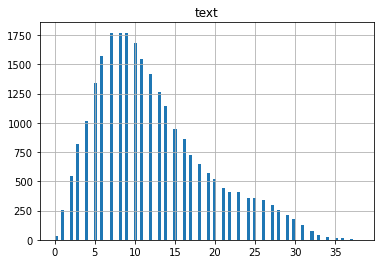

count    25800.000000
mean        12.166744
std          6.977070
min          0.000000
25%          7.000000
50%         11.000000
75%         16.000000
max         38.000000
Name: tokenized_count, dtype: float64


In [18]:
# finding a suitable sequence length
# populate the list with length of the questions

length_df = pd.DataFrame({'text': df['tokenized_count']})
length_df.hist(bins=100)
plt.show()
print(df['tokenized_count'].describe())

Finding most common tags

In [97]:
freq= {}
for i in df['tags']:
  for j in i:
    if j in freq.keys():
      freq[j] = freq[j] + 1
    else:
      freq[j] = 1

len(freq)

2334

In [98]:
tag_freq = np.array(list(freq.values()))
print(tag_freq.mean())
print(tag_freq.std())

33.54198800342759
175.81438051159753


In [99]:
freq = dict(sorted(freq.items(), key=lambda x:x[1], reverse=True))
common_tags = list(freq.keys())[:200]

In [100]:
list(freq.items())[:200]

[('ปัญหาความรัก', 3347),
 ('การเมือง', 3226),
 ('หุ้น', 2713),
 ('ศาสนาพุทธ', 2622),
 ('ประสบการณ์ความรัก', 2233),
 ('ความงาม', 1843),
 ('รัฐบาล', 1702),
 ('ศาสนา', 1445),
 ('ประสบการณ์ชีวิตคู่', 1401),
 ('ความรักวัยรุ่น', 1362),
 ('โรคติดเชื้อไวรัสโคโรนาสายพันธุ์ใหม่ 2019 (COVID-19)', 1250),
 ('ปฏิบัติธรรม', 1216),
 ('การลงทุน', 953),
 ('Skin Care', 945),
 ('ธนาคาร', 938),
 ('สิว', 929),
 ('พระไตรปิฎก', 910),
 ('ความรักวัยทำงาน', 896),
 ('การเงิน', 831),
 ('ศาลาคนเศร้า', 821),
 ('ลดความอ้วน', 759),
 ('ข่าวเศรษฐกิจ', 739),
 ('คลินิกความงาม', 728),
 ('วัด', 722),
 ('นักการเมือง', 703),
 ('ทำบุญ', 693),
 ('ศาลาคนโสด', 643),
 ('แอบรัก', 633),
 ('ศัลยกรรมความงาม', 626),
 ('แฟชั่น', 587),
 ('ปัญหาชีวิต', 537),
 ('เครื่องสำอาง', 535),
 ('ทำผม', 535),
 ('ตลาดหลักทรัพย์', 531),
 ('ปัญหาวัยรุ่น', 490),
 ('พิธีกรรมทางศาสนา', 450),
 ('Technical Analysis', 437),
 ('สุขภาพกาย', 428),
 ('ความรักต่างวัย', 417),
 ('มหาสติปัฏฐาน 4', 413),
 ('ออกกำลังกาย', 411),
 ('บัตรเครดิต', 411),
 ('การ์ตูนการเมือง'

In [101]:
def common_tags_exis(tags_list):
  for tag in tags_list:
    if tag in common_tags:
      return True
  return False

In [102]:
filter_common_df = df[df['tags'].apply(common_tags_exis)]
filter_common_df["common_tags"] = filter_common_df['tags'].apply(lambda x: list(filter(lambda x: x in common_tags, x)))
print(filter_common_df['common_tags'])
print(filter_common_df.shape)

0       [ศาลาคนโสด, หาเพื่อน, ศาลาคนเศร้า, ประสบการณ์ค...
1                                     [ประสบการณ์ความรัก]
2       [ความรักต่างวัย, ความรักวัยรุ่น, ความรักเพศที่...
3                                [ความรักวัยรุ่น, แอบรัก]
4                                        [ความรักวัยรุ่น]
                              ...                        
5145                                               [หุ้น]
5146    [หุ้น, บริษัทหลักทรัพย์, ตลาดหลักทรัพย์, กองทุ...
5147                                           [การลงทุน]
5148                  [สินเชื่อเพื่อที่อยู่อาศัย, ธนาคาร]
5149    [ตลาดหลักทรัพย์, หุ้น, การลงทุน, ตลาดหลักทรัพย...
Name: common_tags, Length: 25771, dtype: object
(25771, 6)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Parse tags to dummy variables

In [103]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(filter_common_df['common_tags'])
y.shape

(25771, 200)

Save Dataframe to csv

In [104]:
filter_common_df.to_csv(directory + '3 Output/filter_common.csv')

## Train, Test Split

In [105]:
x_tr, x_val, y_tr, y_val = train_test_split(filter_common_df['tokenized'], y, test_size=0.2, random_state=0, shuffle=True)
print(x_tr.shape, y_tr.shape)
print(x_val.shape, y_val.shape)

(20616,) (20616, 200)
(5155,) (5155, 200)


## Pad Sequences

In [106]:
max_len = 10

In [107]:
# custom texts to sequences
def texts_to_sequences(text_list):
  sequences = []
  for text in text_list:
    temp_list = []
    for word in text:
      temp_list.append(word_index[word]) if word in word_index else 0 # ignore unknown words
    sequences.append(temp_list)
  return sequences

In [108]:
x_tr_seq = texts_to_sequences(x_tr)
x_val_seq = texts_to_sequences(x_val)

x_tr_seq = pad_sequences(x_tr_seq,  padding='post', maxlen=max_len, value=word_index[''])
x_val_seq = pad_sequences(x_val_seq, padding='post', maxlen=max_len, value=word_index[''])
print(x_tr_seq.shape)
print(x_val_seq.shape)
print('Example of pading: ' + str(x_tr_seq[0]))

(20616, 10)
(5155, 10)
Example of pading: [11014 11474 10316  6163 14546  5862 16063 16063 16063 16063]


## Deep Learning Model

In [109]:
num_words = len(word_index)
num_labels = y.shape[1]
num_embedding_dim = len(word_vectors[0])
num_words, num_labels, num_embedding_dim

(16064, 200, 2304)

#### Simple RNN

In [ ]:
def create_simple_RNN_model():
  # define model architecture
  k.clear_session()

  #sequential model
  model = Sequential()

  #embedding layer
  model.add(Embedding(num_words,
                      output_dim=num_embedding_dim,
                      weights = [np.array(word_vectors)],
                      input_length=max_len,
                      mask_zero=False,
                      trainable=False))

  #lstm 
  model.add(SimpleRNN(128, return_sequences=True))
  model.add(SimpleRNN(128))

  #dense layer
  model.add(Dense(1024, activation='relu')) 
  model.add(Dropout(0.5))

  #output layer
  model.add(Dense(num_labels ,activation='sigmoid'))

  model.compile(optimizer='adam', loss='binary_crossentropy')

  model.fit(x_tr_seq, y_tr, batch_size=128, epochs=25, verbose=1, validation_data=(x_val_seq, y_val))

  return model

In [51]:
if os.path.isfile(directory + '2 Pickle/rnn_model.h5'):
  rnn_model = keras.models.load_model(directory + '2 Pickle/rnn_model.h5')
else:
  rnn_model = create_simple_RNN_model()
  rnn_model.save(directory + '2 Pickle/rnn_model.h5')

#### LSTM

In [111]:
def create_LSTM_model():
  # define model architecture
  k.clear_session()

  #sequential model
  model = Sequential()

  #embedding layer
  model.add(Embedding(num_words,
                      output_dim=num_embedding_dim,
                      weights = [np.array(word_vectors)],
                      input_length=max_len,
                      mask_zero=False,
                      trainable=False))

  #lstm 
  model.add(LSTM(128, return_sequences=True))
  model.add(LSTM(128))

  #dense layer
  model.add(Dense(1024, activation='relu')) 
  model.add(Dropout(0.5))

  #output layer
  model.add(Dense(num_labels ,activation='sigmoid'))

  model.compile(optimizer='adam', loss='binary_crossentropy')

  model.fit(x_tr_seq, y_tr, batch_size=128, epochs=25, verbose=1, validation_data=(x_val_seq, y_val))

  return model

In [50]:
if os.path.isfile(directory + '2 Pickle/lstm_model.h5'):
  lstm_model = keras.models.load_model(directory + '2 Pickle/lstm_model.h5')
else:
  lstm_model = create_LSTM_model()
  lstm_model.save(directory + '2 Pickle/lstm_model.h5')

In [112]:
lstm_model = create_LSTM_model()
lstm_model.save(directory + '2 Pickle/lstm_model.h5')

Epoch 1/25
162/162 [==============================] - 48s 234ms/step - loss: 0.1535 - val_loss: 0.0604
Epoch 2/25
162/162 [==============================] - 36s 225ms/step - loss: 0.0618 - val_loss: 0.0602
Epoch 3/25
162/162 [==============================] - 37s 226ms/step - loss: 0.0615 - val_loss: 0.0598
Epoch 4/25
162/162 [==============================] - 37s 227ms/step - loss: 0.0602 - val_loss: 0.0571
Epoch 5/25
162/162 [==============================] - 37s 226ms/step - loss: 0.0574 - val_loss: 0.0553
Epoch 6/25
162/162 [==============================] - 37s 226ms/step - loss: 0.0562 - val_loss: 0.0544
Epoch 7/25
162/162 [==============================] - 37s 226ms/step - loss: 0.0548 - val_loss: 0.0536
Epoch 8/25
162/162 [==============================] - 36s 225ms/step - loss: 0.0532 - val_loss: 0.0529
Epoch 9/25
162/162 [==============================] - 37s 227ms/step - loss: 0.0521 - val_loss: 0.0521
Epoch 10/25
162/162 [==============================] - 37s 227ms/step - l

#### GRU

In [ ]:
def create_GRU_model():
  # define model architecture
  k.clear_session()

  #sequential model
  model = Sequential()

  #embedding layer
  model.add(Embedding(num_words,
                      output_dim=num_embedding_dim,
                      weights = [np.array(word_vectors)],
                      input_length=max_len,
                      mask_zero=False,
                      trainable=False))

  #lstm 
  model.add(GRU(128, return_sequences=True))
  model.add(GRU(128))

  #dense layer
  model.add(Dense(1024, activation='relu')) 
  model.add(Dropout(0.5))

  #output layer
  model.add(Dense(num_labels ,activation='sigmoid'))

  model.compile(optimizer='adam', loss='binary_crossentropy')

  model.fit(x_tr_seq, y_tr, batch_size=128, epochs=25, verbose=1, validation_data=(x_val_seq, y_val))

  return model

In [52]:
if os.path.isfile(directory + '2 Pickle/gru_model.h5'):
  gru_model = keras.models.load_model(directory + '2 Pickle/gru_model.h5')
else:
  gru_model = create_GRU_model()
  gru_model.save(directory + '2 Pickle/gru_model.h5')

## Predict

In [ ]:
model = lstm_model

In [113]:
pred_prob = model.predict(x_val_seq)
pred_prob[0]

array([1.23800100e-06, 9.59202316e-06, 1.58169866e-03, 4.70872365e-05,
       4.51056476e-05, 7.42793083e-04, 8.54998827e-04, 6.05131245e-05,
       4.86072898e-03, 4.89342213e-03, 2.49084830e-03, 3.02724084e-06,
       2.79065669e-02, 6.33522868e-03, 7.77384639e-03, 6.52372837e-04,
       9.39160585e-03, 4.51392233e-02, 5.17374277e-03, 1.82603599e-05,
       4.48483734e-05, 3.97843122e-03, 4.99046450e-07, 3.95638295e-07,
       1.39643518e-07, 1.31628513e-02, 5.28872013e-04, 6.48915768e-04,
       1.91894174e-03, 3.72022390e-04, 2.38694549e-02, 3.68170440e-01,
       3.51420939e-02, 2.59940028e-02, 1.26160979e-02, 2.10533440e-02,
       8.35523009e-03, 4.41607833e-03, 7.54755735e-03, 1.83606148e-02,
       1.13620205e-04, 5.35760046e-06, 3.35186720e-04, 1.58905983e-04,
       1.94786353e-05, 2.74419785e-04, 3.03354245e-05, 1.36077233e-05,
       7.32077160e-06, 1.05059147e-03, 6.37471676e-04, 6.67947531e-03,
       1.86006946e-06, 2.01291386e-05, 1.11927839e-04, 1.41948462e-04,
      

In [114]:
#define candidate threshold values
threshold = np.arange(0, 0.5, 0.1)
threshold

array([0. , 0.1, 0.2, 0.3, 0.4])

In [115]:
def classify(pred_prob,thresh):
  y_pred_seq = []

  for i in pred_prob:
    temp=[]
    for j in i:
      if j>=thresh:
        temp.append(1)
      else:
        temp.append(0)
    y_pred_seq.append(temp)

  return y_pred_seq

In [116]:
#convert to 1 array
y_true = np.array(y_val).ravel() 

In [75]:
score=[]

#convert to 1 array
y_true = np.array(y_val).ravel() 

for thresh in threshold:
  #classes for each threshold
  y_pred_seq = classify(pred_prob,thresh) 

  #convert to 1d array
  y_pred = np.array(y_pred_seq).ravel()

  score.append(metrics.f1_score(y_true,y_pred))

opt = threshold[score.index(max(score))]
opt

0.30000000000000004

In [117]:
y_pred_seq = classify(pred_prob, 0.24)
y_pred = np.array(y_pred_seq).ravel()
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [118]:
print(metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1017665
           1       0.41      0.34      0.37     13335

    accuracy                           0.99   1031000
   macro avg       0.70      0.67      0.68   1031000
weighted avg       0.98      0.99      0.98   1031000



In [119]:
y_pred = mlb.inverse_transform(np.array(y_pred_seq))
y_true = mlb.inverse_transform(np.array(y_val))

prediction_df = pd.DataFrame({'comment':x_val,'actual':y_true,'predictions':y_pred})
prediction_df

comment  ...                                        predictions
2172  [ข่าว, ดี้, ดี, ., นายกฯ, นำ, ทีม, ถ่ายภาพ, ปร...  ...                                 (การเมือง, รัฐบาล)
3591            [เหมียน, เดิม, ---, มิ.ย., ปลายปี, ---]  ...                                            (หุ้น,)
2822  [:, in, ปิดกิจการ, -, ตกงาน, เพียบ, /, สปา, ภู...  ...  (การเมือง, หุ้น, โรคติดเชื้อไวรัสโคโรนาสายพันธ...
2419  [แฟน, ชอบ, พูด, ประชด, ว่า, เป็น, คุณนาย, คุณผ...  ...                  (ประสบการณ์ความรัก, ปัญหาความรัก)
2378  [ปัจจุบัน, การ, เสริม, ซีเมนต์, ใน, กระดูกสันห...  ...          (คลินิกความงาม, ความงาม, ศัลยกรรมความงาม)
...                                                 ...  ...                                                ...
3432  [จาก, รังสิต, ไป, วัด, สัก, ใหญ่, นนทบุรี, ไป,...  ...                                   (วัด, ศาสนาพุทธ)
1714  [เธอ, บอ, กว่า, กลัว, คน, มอง, ไม่, ดี, เพราะว...  ...  (ความรักวัยรุ่น, ประสบการณ์ความรัก, ประสบการณ์...
794                                  [ตามหา, สบู่, !!!]  ...                                    (ความงาม, ทำผม)
1935                           [แอ, ป, ธนาคาร, กรุงเทพ]  ...                           (ธนาคาร, ธนาคารกสิกรไทย)
722                   [โควิด, ลูกผสม, ที่, เวียดนาม, ?]  ...                                 (การเมือง, รัฐบาล)

[5155 rows x 3 columns]

In [120]:
prediction_df.to_csv(directory + '3 Output/prediction-lstm.csv')

In [64]:
def predict_tag(comment, opt=opt):  
  text=[]  
  text = [cleansing_text(comment)]
  text = [tokenize_word_with_wangchangerta(comment)]
  #seq = x_tokenizer.texts_to_sequences(text)
  seq = texts_to_sequences(text)

  pad_seq = pad_sequences(seq,  padding='post', maxlen=max_len, value=word_index[''])
  pred_prob = model.predict(pad_seq)
  classes = classify(pred_prob,opt)[0]
  classes = np.array([classes])
  classes = mlb.inverse_transform(classes)  
  return classes

In [46]:
comment = "ขอถามความหมายของคำบาลีค่ะ"
print(predict_tag(comment, opt))

NameError: ignored

In [ ]:
comment = "ทั่วสากลจักรวาล มีพระพุทธเจ้ามากมาย ดั่งเม็ดทรายในจักรวาล"
print(predict_tag(comment, opt))

In [ ]:
comment = "เราอยากย้ายบ้านใหม่ค่ะ พอมีคาถาอะไรที่สวดแล้วทำให้เรื่องนี้คล่องตัวไหมคะ พระพุทธเจ้า"
print(predict_tag(comment, opt))

In [ ]:
comment = "กราบเรียนถามผู้รู้ ว่า นิพพาน เที่ยง หรือไม่???"
print(predict_tag(comment, opt))

In [ ]:
comment = "วิ่งแล้วน่องใหญ่จริงไหม"
print(predict_tag(comment, opt))